In [5]:
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append('..')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (11,8)
from merf.utils import MERFDataGenerator
from merf.merf import MERF

# Experimental Setup

There are some global parameters for all the experiments. Each experiment is run N_per_experiment times. The experiment itself is parametrized by three parameters of the generative model. We collect up the results of the experiments in a big list of dictinaries. This is then used to compute certain summary statistics after all the experiments are over.

In [107]:
# Globals
num_clusters_each_size = 20
train_sizes = [1, 3, 5, 7, 9]
known_sizes = [9, 27, 45, 63, 81]
new_sizes = [10, 30, 50, 70, 90]
n_estimators = 300
max_iterations = 100
train_cluster_sizes = MERFDataGenerator.create_cluster_sizes_array(train_sizes, num_clusters_each_size)
known_cluster_sizes = MERFDataGenerator.create_cluster_sizes_array(known_sizes, num_clusters_each_size)
new_cluster_sizes = MERFDataGenerator.create_cluster_sizes_array(new_sizes, num_clusters_each_size)

In [108]:
# Number of times to run each experiemnts 
N_per_experiment = 10

In [8]:
# Defining the experiments to run
experiments = [{'id': 0, 'm': .8, 'sigma_b_sq': 0.9, 'sigma_e': 1},
               {'id': 1, 'm': .7, 'sigma_b_sq': 2.7, 'sigma_e': 1},
               {'id': 2, 'm': .6, 'sigma_b_sq': 4.5, 'sigma_e': 1},
               {'id': 3, 'm': .3, 'sigma_b_sq': 0.2, 'sigma_e': 1},
               {'id': 4, 'm': .3, 'sigma_b_sq': 0.5, 'sigma_e': 1},
               {'id': 5, 'm': .2, 'sigma_b_sq': 0.8, 'sigma_e': 1}]

# Run Experiments

In [110]:
# Creating a dictionary to hold the results of the experiments
results = []
for experiment in experiments:
    results.append({'id': experiment['id'], 'ptev': [], 'prev': [],
                    'mse_known_rf_fixed': [], 'mse_known_rf_ohe': [], 'mse_known_merf': [], 
                    'mse_new_rf_fixed': [], 'mse_new_rf_ohe': [], 'mse_new_merf': []})
    
for experiment, result in zip(experiments, results): 
    for experiment_iteration in range(0, N_per_experiment):
        print("Experiment iteration: {}".format(experiment_iteration))
        # Generate data for experiment
        dgm = MERFDataGenerator(m=experiment['m'], sigma_b=np.sqrt(experiment['sigma_b_sq']), sigma_e=experiment['sigma_e'])
        train, test_known, test_new, train_cluster_ids, ptev, prev = dgm.generate_split_samples(train_cluster_sizes, known_cluster_sizes, new_cluster_sizes)
        
        # Store off PTEV and PREV
        result['ptev'].append(ptev)
        result['prev'].append(prev)
        
        # Training Data Extract
        X_train = train[['X_0', 'X_1', 'X_2']]
        Z_train = train[['Z']]
        clusters_train = train['cluster']
        y_train = train['y']

        # Known Cluster Data Extract
        X_known = test_known[['X_0', 'X_1', 'X_2']]
        Z_known = test_known[['Z']]
        clusters_known = test_known['cluster']
        y_known = test_known['y']

        # New Cluster Data Extract
        X_new = test_new[['X_0', 'X_1', 'X_2']]
        Z_new = test_new[['Z']]
        clusters_new = test_new['cluster']
        y_new = test_new['y']

        # MERF
        print("---------------------MERF----------------------")
        mrf = MERF(n_estimators=n_estimators, max_iterations=max_iterations)
        mrf.fit(X_train, Z_train, clusters_train, y_train)
        y_hat_known_merf = mrf.predict(X_known, Z_known, clusters_known)
        y_hat_new_merf = mrf.predict(X_new, Z_new, clusters_new)
        mse_known_merf = np.mean((y_known - y_hat_known_merf) ** 2)
        mse_new_merf = np.mean((y_new - y_hat_new_merf) ** 2)
        result['mse_known_merf'].append(mse_known_merf)
        result['mse_new_merf'].append(mse_new_merf)

        # Random Forest Fixed Only 
        print("---------------------Random Forest Fixed Effect Only----------------------")
        rf = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_hat_known_rf_fixed = rf.predict(X_known)
        y_hat_new_rf_fixed = rf.predict(X_new)
        mse_known_rf_fixed = np.mean((y_known - y_hat_known_rf_fixed) ** 2)
        mse_new_rf_fixed = np.mean((y_new - y_hat_new_rf_fixed) ** 2)
        result['mse_known_rf_fixed'].append(mse_known_rf_fixed)
        result['mse_new_rf_fixed'].append(mse_new_rf_fixed)
        
        # Random Forest with OHE Cluster
        print("---------------------Random Forest w OHE Cluster----------------------")
        X_train_w_ohe = MERFDataGenerator.create_X_with_ohe_clusters(X_train, clusters_train, train_cluster_ids)
        X_known_w_ohe = MERFDataGenerator.create_X_with_ohe_clusters(X_known, clusters_known, train_cluster_ids)
        X_new_w_ohe = MERFDataGenerator.create_X_with_ohe_clusters(X_new, clusters_new, train_cluster_ids)
        rf_ohe = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1)
        rf_ohe.fit(X_train_w_ohe, y_train)
        y_hat_known_rf_ohe = rf_ohe.predict(X_known_w_ohe)
        y_hat_new_rf_ohe = rf_ohe.predict(X_new_w_ohe)
        mse_known_rf_ohe = np.mean((y_known - y_hat_known_rf_ohe) ** 2)
        mse_new_rf_ohe = np.mean((y_new - y_hat_new_rf_ohe) ** 2)
        result['mse_known_rf_ohe'].append(mse_known_rf_ohe)
        result['mse_new_rf_ohe'].append(mse_new_rf_ohe)


INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 89.71798312729888, PREV = 10.31433706250505.


Experiment iteration: 0
---------------------MERF----------------------


INFO     [merf.py:235] GLL is 817.2084771785458 at iteration 1.
INFO     [merf.py:235] GLL is 744.7817615866038 at iteration 2.
INFO     [merf.py:235] GLL is 748.2692323173289 at iteration 3.
INFO     [merf.py:235] GLL is 739.6616680287646 at iteration 4.
INFO     [merf.py:235] GLL is 754.3298028223711 at iteration 5.
INFO     [merf.py:235] GLL is 759.3058486480606 at iteration 6.
INFO     [merf.py:235] GLL is 746.8098910162707 at iteration 7.
INFO     [merf.py:235] GLL is 758.9924555201624 at iteration 8.
INFO     [merf.py:235] GLL is 749.2498248648724 at iteration 9.
INFO     [merf.py:235] GLL is 756.1969368387448 at iteration 10.
INFO     [merf.py:235] GLL is 752.2815889281281 at iteration 11.
INFO     [merf.py:235] GLL is 749.2938322968797 at iteration 12.
INFO     [merf.py:235] GLL is 756.9831533237007 at iteration 13.
INFO     [merf.py:235] GLL is 757.5975597918039 at iteration 14.
INFO     [merf.py:235] GLL is 758.6151743060099 at iteration 15.
INFO     [merf.py:235] GLL is 748.

---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 89.82845754059677, PREV = 10.190966720457933.


Experiment iteration: 1
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 1112.692896063652 at iteration 1.
INFO     [merf.py:235] GLL is 1038.8161570331272 at iteration 2.
INFO     [merf.py:235] GLL is 1016.8979999684675 at iteration 3.
INFO     [merf.py:235] GLL is 1034.1181233394798 at iteration 4.
INFO     [merf.py:235] GLL is 1041.7455126283503 at iteration 5.
INFO     [merf.py:235] GLL is 1043.3413927700872 at iteration 6.
INFO     [merf.py:235] GLL is 1034.8674691598587 at iteration 7.
INFO     [merf.py:235] GLL is 1036.9775695319272 at iteration 8.
INFO     [merf.py:235] GLL is 1026.5108590581667 at iteration 9.
INFO     [merf.py:235] GLL is 1032.502353083904 at iteration 10.
INFO     [merf.py:235] GLL is 1019.9217966954567 at iteration 11.
INFO     [merf.py:235] GLL is 1044.9206527380106 at iteration 12.
INFO     [merf.py:235] GLL is 1032.3270341862826 at iteration 13.
INFO     [merf.py:235] GLL is 1033.714620646034 at iteration 14.
INFO     [merf.py:235] GLL is 1033.7070544603382 at iteration 15.
INFO     [merf.py:235]


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 90.14705273936468, PREV = 9.836874601114422.


Experiment iteration: 2
---------------------MERF----------------------


INFO     [merf.py:235] GLL is 1012.4500230784279 at iteration 1.
INFO     [merf.py:235] GLL is 988.6995963928698 at iteration 2.
INFO     [merf.py:235] GLL is 995.2649480072268 at iteration 3.
INFO     [merf.py:235] GLL is 986.3940639382396 at iteration 4.
INFO     [merf.py:235] GLL is 987.6628705817316 at iteration 5.
INFO     [merf.py:235] GLL is 1010.1440667403444 at iteration 6.
INFO     [merf.py:235] GLL is 997.2473997872623 at iteration 7.
INFO     [merf.py:235] GLL is 986.7369652196877 at iteration 8.
INFO     [merf.py:235] GLL is 980.9151374705262 at iteration 9.
INFO     [merf.py:235] GLL is 968.2947087241689 at iteration 10.
INFO     [merf.py:235] GLL is 992.393478031363 at iteration 11.
INFO     [merf.py:235] GLL is 995.5244814508377 at iteration 12.
INFO     [merf.py:235] GLL is 991.1398120531601 at iteration 13.
INFO     [merf.py:235] GLL is 981.1480812898943 at iteration 14.
INFO     [merf.py:235] GLL is 991.4199317353847 at iteration 15.
INFO     [merf.py:235] GLL is 984

---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 90.05454483697068, PREV = 9.939431333455273.


Experiment iteration: 3
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 981.5397617779056 at iteration 1.
INFO     [merf.py:235] GLL is 927.7111629875326 at iteration 2.
INFO     [merf.py:235] GLL is 930.2780263623705 at iteration 3.
INFO     [merf.py:235] GLL is 923.5544277838135 at iteration 4.
INFO     [merf.py:235] GLL is 926.8002435602759 at iteration 5.
INFO     [merf.py:235] GLL is 920.5361755200005 at iteration 6.
INFO     [merf.py:235] GLL is 918.4468668948366 at iteration 7.
INFO     [merf.py:235] GLL is 924.7923314719471 at iteration 8.
INFO     [merf.py:235] GLL is 918.859364808112 at iteration 9.
INFO     [merf.py:235] GLL is 917.5812136396884 at iteration 10.
INFO     [merf.py:235] GLL is 931.2532435032201 at iteration 11.
INFO     [merf.py:235] GLL is 923.346897638833 at iteration 12.
INFO     [merf.py:235] GLL is 924.9754105644139 at iteration 13.
INFO     [merf.py:235] GLL is 920.0854411441496 at iteration 14.
INFO     [merf.py:235] GLL is 923.6398222266117 at iteration 15.
INFO     [merf.py:235] GLL is 930.76


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 89.9154591373451, PREV = 10.094022611312898.


Experiment iteration: 4
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 876.8384430060706 at iteration 1.
INFO     [merf.py:235] GLL is 839.9043105763957 at iteration 2.
INFO     [merf.py:235] GLL is 849.9572792761827 at iteration 3.
INFO     [merf.py:235] GLL is 824.2579850578661 at iteration 4.
INFO     [merf.py:235] GLL is 837.636383817288 at iteration 5.
INFO     [merf.py:235] GLL is 831.6240167388958 at iteration 6.
INFO     [merf.py:235] GLL is 833.8086492827471 at iteration 7.
INFO     [merf.py:235] GLL is 841.2739000966857 at iteration 8.
INFO     [merf.py:235] GLL is 831.4392616742275 at iteration 9.
INFO     [merf.py:235] GLL is 837.8268039169294 at iteration 10.
INFO     [merf.py:235] GLL is 835.2800865051391 at iteration 11.
INFO     [merf.py:235] GLL is 845.1875069924777 at iteration 12.
INFO     [merf.py:235] GLL is 830.2996823584926 at iteration 13.
INFO     [merf.py:235] GLL is 826.9500843351332 at iteration 14.
INFO     [merf.py:235] GLL is 842.1853800699165 at iteration 15.
INFO     [merf.py:235] GLL is 830.0


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 89.87532740428294, PREV = 10.138717264590582.


Experiment iteration: 5
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 1018.4139152152457 at iteration 1.
INFO     [merf.py:235] GLL is 906.4426567576744 at iteration 2.
INFO     [merf.py:235] GLL is 919.5877962896103 at iteration 3.
INFO     [merf.py:235] GLL is 904.9507585663316 at iteration 4.
INFO     [merf.py:235] GLL is 910.2100309120565 at iteration 5.
INFO     [merf.py:235] GLL is 924.7000158831386 at iteration 6.
INFO     [merf.py:235] GLL is 930.5622185900789 at iteration 7.
INFO     [merf.py:235] GLL is 919.7239384096754 at iteration 8.
INFO     [merf.py:235] GLL is 927.318501880116 at iteration 9.
INFO     [merf.py:235] GLL is 938.3248599280703 at iteration 10.
INFO     [merf.py:235] GLL is 933.3584787382387 at iteration 11.
INFO     [merf.py:235] GLL is 923.1916972975122 at iteration 12.
INFO     [merf.py:235] GLL is 908.9821426109795 at iteration 13.
INFO     [merf.py:235] GLL is 920.0311914906817 at iteration 14.
INFO     [merf.py:235] GLL is 926.2348555901096 at iteration 15.
INFO     [merf.py:235] GLL is 922.


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 89.78303996360474, PREV = 10.241649242978637.


Experiment iteration: 6
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 916.7406404160876 at iteration 1.
INFO     [merf.py:235] GLL is 844.366488618833 at iteration 2.
INFO     [merf.py:235] GLL is 866.3248981649645 at iteration 3.
INFO     [merf.py:235] GLL is 857.0203132435103 at iteration 4.
INFO     [merf.py:235] GLL is 845.6425020221753 at iteration 5.
INFO     [merf.py:235] GLL is 860.5088398312059 at iteration 6.
INFO     [merf.py:235] GLL is 863.5072574737422 at iteration 7.
INFO     [merf.py:235] GLL is 857.5876714438668 at iteration 8.
INFO     [merf.py:235] GLL is 867.4960991917444 at iteration 9.
INFO     [merf.py:235] GLL is 858.5288397743498 at iteration 10.
INFO     [merf.py:235] GLL is 856.2132095530632 at iteration 11.
INFO     [merf.py:235] GLL is 867.7427685105616 at iteration 12.
INFO     [merf.py:235] GLL is 855.1094488238125 at iteration 13.
INFO     [merf.py:235] GLL is 867.3292196010937 at iteration 14.
INFO     [merf.py:235] GLL is 850.1217623062214 at iteration 15.
INFO     [merf.py:235] GLL is 847.9


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 90.13775444665501, PREV = 9.847173420837173.


Experiment iteration: 7
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 1261.4154918094719 at iteration 1.
INFO     [merf.py:235] GLL is 1193.2584843418922 at iteration 2.
INFO     [merf.py:235] GLL is 1187.4351610436104 at iteration 3.
INFO     [merf.py:235] GLL is 1200.848949288287 at iteration 4.
INFO     [merf.py:235] GLL is 1223.917075152296 at iteration 5.
INFO     [merf.py:235] GLL is 1226.8113992165463 at iteration 6.
INFO     [merf.py:235] GLL is 1224.1515021273603 at iteration 7.
INFO     [merf.py:235] GLL is 1202.799377101986 at iteration 8.
INFO     [merf.py:235] GLL is 1182.2202925366958 at iteration 9.
INFO     [merf.py:235] GLL is 1195.857802704767 at iteration 10.
INFO     [merf.py:235] GLL is 1207.0759425101462 at iteration 11.
INFO     [merf.py:235] GLL is 1192.4072369744972 at iteration 12.
INFO     [merf.py:235] GLL is 1191.6980760910897 at iteration 13.
INFO     [merf.py:235] GLL is 1206.7268629308785 at iteration 14.
INFO     [merf.py:235] GLL is 1207.1624111535505 at iteration 15.
INFO     [merf.py:235] 


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 89.72327745877637, PREV = 10.30841778082703.


Experiment iteration: 8
---------------------MERF----------------------


INFO     [merf.py:235] GLL is 976.6838441966427 at iteration 1.
INFO     [merf.py:235] GLL is 946.5801129972558 at iteration 2.
INFO     [merf.py:235] GLL is 939.2443711744716 at iteration 3.
INFO     [merf.py:235] GLL is 934.0285676248897 at iteration 4.
INFO     [merf.py:235] GLL is 925.0607040517068 at iteration 5.
INFO     [merf.py:235] GLL is 936.4612880702 at iteration 6.
INFO     [merf.py:235] GLL is 936.4845379394329 at iteration 7.
INFO     [merf.py:235] GLL is 929.1846028637552 at iteration 8.
INFO     [merf.py:235] GLL is 929.5242629680821 at iteration 9.
INFO     [merf.py:235] GLL is 935.2674548923441 at iteration 10.
INFO     [merf.py:235] GLL is 932.004553672664 at iteration 11.
INFO     [merf.py:235] GLL is 936.6631562142791 at iteration 12.
INFO     [merf.py:235] GLL is 929.9898171046899 at iteration 13.
INFO     [merf.py:235] GLL is 920.6127067760737 at iteration 14.
INFO     [merf.py:235] GLL is 927.2440979289953 at iteration 15.
INFO     [merf.py:235] GLL is 929.6205

---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 89.92004770682647, PREV = 10.088914869611958.


Experiment iteration: 9
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 1018.0538748705791 at iteration 1.
INFO     [merf.py:235] GLL is 981.4015842699677 at iteration 2.
INFO     [merf.py:235] GLL is 973.4928078312953 at iteration 3.
INFO     [merf.py:235] GLL is 979.237095281599 at iteration 4.
INFO     [merf.py:235] GLL is 981.1171070747343 at iteration 5.
INFO     [merf.py:235] GLL is 970.7286488528191 at iteration 6.
INFO     [merf.py:235] GLL is 976.9340933638739 at iteration 7.
INFO     [merf.py:235] GLL is 976.5301133096785 at iteration 8.
INFO     [merf.py:235] GLL is 972.0750794195468 at iteration 9.
INFO     [merf.py:235] GLL is 970.6760301332032 at iteration 10.
INFO     [merf.py:235] GLL is 991.2147970220783 at iteration 11.
INFO     [merf.py:235] GLL is 973.0496694148331 at iteration 12.
INFO     [merf.py:235] GLL is 960.4748082233594 at iteration 13.
INFO     [merf.py:235] GLL is 981.5830271533085 at iteration 14.
INFO     [merf.py:235] GLL is 981.4687793396859 at iteration 15.
INFO     [merf.py:235] GLL is 976.


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 89.7364743716281, PREV = 30.8809983795905.


Experiment iteration: 0
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 1047.6472235945714 at iteration 1.
INFO     [merf.py:235] GLL is 916.2007333392348 at iteration 2.
INFO     [merf.py:235] GLL is 907.6378713383084 at iteration 3.
INFO     [merf.py:235] GLL is 905.2217190119223 at iteration 4.
INFO     [merf.py:235] GLL is 904.8208498114611 at iteration 5.
INFO     [merf.py:235] GLL is 902.4031513763807 at iteration 6.
INFO     [merf.py:235] GLL is 909.2371123109461 at iteration 7.
INFO     [merf.py:235] GLL is 898.4566060004439 at iteration 8.
INFO     [merf.py:235] GLL is 905.1240521779185 at iteration 9.
INFO     [merf.py:235] GLL is 898.7868712663845 at iteration 10.
INFO     [merf.py:235] GLL is 899.8811590882009 at iteration 11.
INFO     [merf.py:235] GLL is 912.4167177407577 at iteration 12.
INFO     [merf.py:235] GLL is 918.1381474842175 at iteration 13.
INFO     [merf.py:235] GLL is 910.3877441013124 at iteration 14.
INFO     [merf.py:235] GLL is 909.2030910950309 at iteration 15.
INFO     [merf.py:235] GLL is 908


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 89.94961027747115, PREV = 30.168059836079607.


Experiment iteration: 1
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 1002.57927039639 at iteration 1.
INFO     [merf.py:235] GLL is 948.3124225780709 at iteration 2.
INFO     [merf.py:235] GLL is 938.9698421076936 at iteration 3.
INFO     [merf.py:235] GLL is 949.0306313718247 at iteration 4.
INFO     [merf.py:235] GLL is 939.0355189701812 at iteration 5.
INFO     [merf.py:235] GLL is 953.896868492387 at iteration 6.
INFO     [merf.py:235] GLL is 946.179703001766 at iteration 7.
INFO     [merf.py:235] GLL is 941.1777416662744 at iteration 8.
INFO     [merf.py:235] GLL is 962.6523717738203 at iteration 9.
INFO     [merf.py:235] GLL is 947.353323592645 at iteration 10.
INFO     [merf.py:235] GLL is 953.259020097172 at iteration 11.
INFO     [merf.py:235] GLL is 941.2156343096946 at iteration 12.
INFO     [merf.py:235] GLL is 947.7516437801104 at iteration 13.
INFO     [merf.py:235] GLL is 947.4769534212677 at iteration 14.
INFO     [merf.py:235] GLL is 955.1112678432391 at iteration 15.
INFO     [merf.py:235] GLL is 954.71336


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 90.06621832894174, PREV = 29.77943451994434.


Experiment iteration: 2
---------------------MERF----------------------


INFO     [merf.py:235] GLL is 1025.5378458176838 at iteration 1.
INFO     [merf.py:235] GLL is 949.5201380523224 at iteration 2.
INFO     [merf.py:235] GLL is 952.7728875594386 at iteration 3.
INFO     [merf.py:235] GLL is 946.2333537748196 at iteration 4.
INFO     [merf.py:235] GLL is 940.5787539139553 at iteration 5.
INFO     [merf.py:235] GLL is 929.5414588919572 at iteration 6.
INFO     [merf.py:235] GLL is 955.9051325290209 at iteration 7.
INFO     [merf.py:235] GLL is 938.4588127194277 at iteration 8.
INFO     [merf.py:235] GLL is 941.9683590316595 at iteration 9.
INFO     [merf.py:235] GLL is 950.0013992845934 at iteration 10.
INFO     [merf.py:235] GLL is 948.3591807662428 at iteration 11.
INFO     [merf.py:235] GLL is 944.3369150401088 at iteration 12.
INFO     [merf.py:235] GLL is 952.3408361800978 at iteration 13.
INFO     [merf.py:235] GLL is 950.6880082947564 at iteration 14.
INFO     [merf.py:235] GLL is 957.655415886113 at iteration 15.
INFO     [merf.py:235] GLL is 966.

---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 89.73715315868779, PREV = 30.87872246464316.


Experiment iteration: 3
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 983.7678599611345 at iteration 1.
INFO     [merf.py:235] GLL is 861.7583970458264 at iteration 2.
INFO     [merf.py:235] GLL is 859.2873998856719 at iteration 3.
INFO     [merf.py:235] GLL is 851.3070505093423 at iteration 4.
INFO     [merf.py:235] GLL is 859.2616846427244 at iteration 5.
INFO     [merf.py:235] GLL is 857.0126166888215 at iteration 6.
INFO     [merf.py:235] GLL is 856.3285648371701 at iteration 7.
INFO     [merf.py:235] GLL is 862.3764563092421 at iteration 8.
INFO     [merf.py:235] GLL is 843.6144867485236 at iteration 9.
INFO     [merf.py:235] GLL is 851.2328992566391 at iteration 10.
INFO     [merf.py:235] GLL is 863.554120134896 at iteration 11.
INFO     [merf.py:235] GLL is 849.4219447240987 at iteration 12.
INFO     [merf.py:235] GLL is 854.6441044992838 at iteration 13.
INFO     [merf.py:235] GLL is 858.0863271239609 at iteration 14.
INFO     [merf.py:235] GLL is 852.0912032347443 at iteration 15.
INFO     [merf.py:235] GLL is 856.8


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 89.96118496816533, PREV = 30.129439263772767.


Experiment iteration: 4
---------------------MERF----------------------


INFO     [merf.py:235] GLL is 1145.8786838484693 at iteration 1.
INFO     [merf.py:235] GLL is 1049.1974045418085 at iteration 2.
INFO     [merf.py:235] GLL is 1043.8324821183521 at iteration 3.
INFO     [merf.py:235] GLL is 1025.5796038424705 at iteration 4.
INFO     [merf.py:235] GLL is 1044.4461157345252 at iteration 5.
INFO     [merf.py:235] GLL is 1032.7771495150832 at iteration 6.
INFO     [merf.py:235] GLL is 1044.1456384858445 at iteration 7.
INFO     [merf.py:235] GLL is 1044.282259881392 at iteration 8.
INFO     [merf.py:235] GLL is 1043.2321662756294 at iteration 9.
INFO     [merf.py:235] GLL is 1040.6970309544986 at iteration 10.
INFO     [merf.py:235] GLL is 1039.575419948266 at iteration 11.
INFO     [merf.py:235] GLL is 1039.8494858191489 at iteration 12.
INFO     [merf.py:235] GLL is 1040.2253243546904 at iteration 13.
INFO     [merf.py:235] GLL is 1044.488894295059 at iteration 14.
INFO     [merf.py:235] GLL is 1036.4751261171177 at iteration 15.
INFO     [merf.py:235]

---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 89.53505314401171, PREV = 31.557870933210193.


Experiment iteration: 5
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 1003.8007343877524 at iteration 1.
INFO     [merf.py:235] GLL is 888.78685430947 at iteration 2.
INFO     [merf.py:235] GLL is 901.198981933428 at iteration 3.
INFO     [merf.py:235] GLL is 898.1031601333918 at iteration 4.
INFO     [merf.py:235] GLL is 900.2298457445913 at iteration 5.
INFO     [merf.py:235] GLL is 895.787968331285 at iteration 6.
INFO     [merf.py:235] GLL is 900.9228639279834 at iteration 7.
INFO     [merf.py:235] GLL is 895.754793035258 at iteration 8.
INFO     [merf.py:235] GLL is 900.7627274098066 at iteration 9.
INFO     [merf.py:235] GLL is 895.0647076037366 at iteration 10.
INFO     [merf.py:235] GLL is 898.4735967772094 at iteration 11.
INFO     [merf.py:235] GLL is 901.0019887941592 at iteration 12.
INFO     [merf.py:235] GLL is 900.5904644711767 at iteration 13.
INFO     [merf.py:235] GLL is 896.3337420798358 at iteration 14.
INFO     [merf.py:235] GLL is 892.2734164972615 at iteration 15.
INFO     [merf.py:235] GLL is 906.2074


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 89.76466125689862, PREV = 30.786519126144302.


Experiment iteration: 6
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 1100.5856328418215 at iteration 1.
INFO     [merf.py:235] GLL is 1022.7308336361549 at iteration 2.
INFO     [merf.py:235] GLL is 1035.9447902751635 at iteration 3.
INFO     [merf.py:235] GLL is 1018.6946247049661 at iteration 4.
INFO     [merf.py:235] GLL is 1039.168356300288 at iteration 5.
INFO     [merf.py:235] GLL is 1024.3159961966264 at iteration 6.
INFO     [merf.py:235] GLL is 1029.4446631296516 at iteration 7.
INFO     [merf.py:235] GLL is 1034.5494820366675 at iteration 8.
INFO     [merf.py:235] GLL is 1036.0770784787555 at iteration 9.
INFO     [merf.py:235] GLL is 1032.9562524351245 at iteration 10.
INFO     [merf.py:235] GLL is 1024.4328970082606 at iteration 11.
INFO     [merf.py:235] GLL is 1020.2339815737676 at iteration 12.
INFO     [merf.py:235] GLL is 1034.5201083466275 at iteration 13.
INFO     [merf.py:235] GLL is 1027.3177097129612 at iteration 14.
INFO     [merf.py:235] GLL is 1019.6850810267509 at iteration 15.
INFO     [merf.py:23


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 89.38585415464289, PREV = 32.061218246998926.


Experiment iteration: 7
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 1100.6887308282298 at iteration 1.
INFO     [merf.py:235] GLL is 989.9550304686231 at iteration 2.
INFO     [merf.py:235] GLL is 994.6017361052395 at iteration 3.
INFO     [merf.py:235] GLL is 991.116799736821 at iteration 4.
INFO     [merf.py:235] GLL is 995.6832594743763 at iteration 5.
INFO     [merf.py:235] GLL is 995.7258594758263 at iteration 6.
INFO     [merf.py:235] GLL is 998.346321631218 at iteration 7.
INFO     [merf.py:235] GLL is 992.1170157643093 at iteration 8.
INFO     [merf.py:235] GLL is 996.3782047081502 at iteration 9.
INFO     [merf.py:235] GLL is 992.1955451265095 at iteration 10.
INFO     [merf.py:235] GLL is 997.2138451127599 at iteration 11.
INFO     [merf.py:235] GLL is 991.4984646009032 at iteration 12.
INFO     [merf.py:235] GLL is 1001.3299388527832 at iteration 13.
INFO     [merf.py:235] GLL is 1001.1060227169461 at iteration 14.
INFO     [merf.py:235] GLL is 1005.5856285767701 at iteration 15.
INFO     [merf.py:235] GLL is 99


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 89.64755246074705, PREV = 31.179443932082624.


Experiment iteration: 8
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 1000.3268672792307 at iteration 1.
INFO     [merf.py:235] GLL is 920.2850674983463 at iteration 2.
INFO     [merf.py:235] GLL is 901.3674821306131 at iteration 3.
INFO     [merf.py:235] GLL is 922.121427798314 at iteration 4.
INFO     [merf.py:235] GLL is 914.1076616268607 at iteration 5.
INFO     [merf.py:235] GLL is 920.7492948475106 at iteration 6.
INFO     [merf.py:235] GLL is 919.7571208159771 at iteration 7.
INFO     [merf.py:235] GLL is 908.064109260704 at iteration 8.
INFO     [merf.py:235] GLL is 908.9404426666927 at iteration 9.
INFO     [merf.py:235] GLL is 913.3371230314968 at iteration 10.
INFO     [merf.py:235] GLL is 927.8197348867772 at iteration 11.
INFO     [merf.py:235] GLL is 918.3904716450284 at iteration 12.
INFO     [merf.py:235] GLL is 927.954100430662 at iteration 13.
INFO     [merf.py:235] GLL is 919.1813312992209 at iteration 14.
INFO     [merf.py:235] GLL is 910.745359879062 at iteration 15.
INFO     [merf.py:235] GLL is 916.477


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 89.52414415358938, PREV = 31.594617354601784.


Experiment iteration: 9
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 1152.625743875798 at iteration 1.
INFO     [merf.py:235] GLL is 997.566950469036 at iteration 2.
INFO     [merf.py:235] GLL is 1015.8209414025414 at iteration 3.
INFO     [merf.py:235] GLL is 1009.1997397044456 at iteration 4.
INFO     [merf.py:235] GLL is 1013.3575806649914 at iteration 5.
INFO     [merf.py:235] GLL is 1015.5821316796671 at iteration 6.
INFO     [merf.py:235] GLL is 1011.635149651275 at iteration 7.
INFO     [merf.py:235] GLL is 1010.225251285362 at iteration 8.
INFO     [merf.py:235] GLL is 1013.4236227975316 at iteration 9.
INFO     [merf.py:235] GLL is 993.2449116891644 at iteration 10.
INFO     [merf.py:235] GLL is 1011.4066409285945 at iteration 11.
INFO     [merf.py:235] GLL is 1003.077489222565 at iteration 12.
INFO     [merf.py:235] GLL is 1006.8565036007993 at iteration 13.
INFO     [merf.py:235] GLL is 1004.7768888758428 at iteration 14.
INFO     [merf.py:235] GLL is 1007.1860718868171 at iteration 15.
INFO     [merf.py:235] GLL


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 89.83893143575852, PREV = 50.89642965286518.


Experiment iteration: 0
---------------------MERF----------------------


INFO     [merf.py:235] GLL is 1285.648037267356 at iteration 1.
INFO     [merf.py:235] GLL is 1055.8299722533477 at iteration 2.
INFO     [merf.py:235] GLL is 1029.0705229380062 at iteration 3.
INFO     [merf.py:235] GLL is 985.7188750323209 at iteration 4.
INFO     [merf.py:235] GLL is 998.3503575771064 at iteration 5.
INFO     [merf.py:235] GLL is 996.5376853984716 at iteration 6.
INFO     [merf.py:235] GLL is 978.6364046861459 at iteration 7.
INFO     [merf.py:235] GLL is 997.0906739436497 at iteration 8.
INFO     [merf.py:235] GLL is 987.6947869703093 at iteration 9.
INFO     [merf.py:235] GLL is 997.0999940529096 at iteration 10.
INFO     [merf.py:235] GLL is 998.1900438570282 at iteration 11.
INFO     [merf.py:235] GLL is 998.1034453124552 at iteration 12.
INFO     [merf.py:235] GLL is 996.4508257182089 at iteration 13.
INFO     [merf.py:235] GLL is 1010.2604276834616 at iteration 14.
INFO     [merf.py:235] GLL is 1004.5851998807005 at iteration 15.
INFO     [merf.py:235] GLL is 

---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 89.92928572793377, PREV = 50.39316598310454.


Experiment iteration: 1
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 1120.3386731155008 at iteration 1.
INFO     [merf.py:235] GLL is 936.8324098151112 at iteration 2.
INFO     [merf.py:235] GLL is 919.0083853549731 at iteration 3.
INFO     [merf.py:235] GLL is 915.0527178185324 at iteration 4.
INFO     [merf.py:235] GLL is 905.1219327068059 at iteration 5.
INFO     [merf.py:235] GLL is 899.9806794185885 at iteration 6.
INFO     [merf.py:235] GLL is 908.1276655023445 at iteration 7.
INFO     [merf.py:235] GLL is 914.7068125045706 at iteration 8.
INFO     [merf.py:235] GLL is 911.7321088999967 at iteration 9.
INFO     [merf.py:235] GLL is 913.991971398992 at iteration 10.
INFO     [merf.py:235] GLL is 905.2244429923511 at iteration 11.
INFO     [merf.py:235] GLL is 916.2843831432949 at iteration 12.
INFO     [merf.py:235] GLL is 907.6673036122079 at iteration 13.
INFO     [merf.py:235] GLL is 911.4941445493225 at iteration 14.
INFO     [merf.py:235] GLL is 909.4971982181715 at iteration 15.
INFO     [merf.py:235] GLL is 914.


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 89.96340791401448, PREV = 50.203372053338.


Experiment iteration: 2
---------------------MERF----------------------


INFO     [merf.py:235] GLL is 1093.468186750158 at iteration 1.
INFO     [merf.py:235] GLL is 925.1206724629969 at iteration 2.
INFO     [merf.py:235] GLL is 912.3052200693843 at iteration 3.
INFO     [merf.py:235] GLL is 895.0137338224375 at iteration 4.
INFO     [merf.py:235] GLL is 888.8061813015627 at iteration 5.
INFO     [merf.py:235] GLL is 894.0642758508432 at iteration 6.
INFO     [merf.py:235] GLL is 891.2156218806847 at iteration 7.
INFO     [merf.py:235] GLL is 890.7978281201918 at iteration 8.
INFO     [merf.py:235] GLL is 888.6459091938801 at iteration 9.
INFO     [merf.py:235] GLL is 896.1611144310251 at iteration 10.
INFO     [merf.py:235] GLL is 895.7864530613201 at iteration 11.
INFO     [merf.py:235] GLL is 902.2610912037175 at iteration 12.
INFO     [merf.py:235] GLL is 894.1887734351029 at iteration 13.
INFO     [merf.py:235] GLL is 898.3312429419381 at iteration 14.
INFO     [merf.py:235] GLL is 895.7134532683186 at iteration 15.
INFO     [merf.py:235] GLL is 896.

---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 90.05429133099851, PREV = 49.698563332207186.


Experiment iteration: 3
---------------------MERF----------------------


INFO     [merf.py:235] GLL is 1053.5093536518752 at iteration 1.
INFO     [merf.py:235] GLL is 832.524524494777 at iteration 2.
INFO     [merf.py:235] GLL is 810.4543443649114 at iteration 3.
INFO     [merf.py:235] GLL is 807.5508204383653 at iteration 4.
INFO     [merf.py:235] GLL is 804.3254606350196 at iteration 5.
INFO     [merf.py:235] GLL is 815.959083312767 at iteration 6.
INFO     [merf.py:235] GLL is 806.6913735600824 at iteration 7.
INFO     [merf.py:235] GLL is 808.1763234348108 at iteration 8.
INFO     [merf.py:235] GLL is 808.9766575547602 at iteration 9.
INFO     [merf.py:235] GLL is 807.3536780090981 at iteration 10.
INFO     [merf.py:235] GLL is 805.727260844297 at iteration 11.
INFO     [merf.py:235] GLL is 817.8529266571181 at iteration 12.
INFO     [merf.py:235] GLL is 811.2455163194966 at iteration 13.
INFO     [merf.py:235] GLL is 811.7205402830864 at iteration 14.
INFO     [merf.py:235] GLL is 814.3492654963555 at iteration 15.
INFO     [merf.py:235] GLL is 814.76

---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 89.90606979501028, PREV = 50.52237966359717.


Experiment iteration: 4
---------------------MERF----------------------


INFO     [merf.py:235] GLL is 1158.0880866402554 at iteration 1.
INFO     [merf.py:235] GLL is 982.2876447427286 at iteration 2.
INFO     [merf.py:235] GLL is 983.4804734950135 at iteration 3.
INFO     [merf.py:235] GLL is 963.6985360496689 at iteration 4.
INFO     [merf.py:235] GLL is 961.5809174453 at iteration 5.
INFO     [merf.py:235] GLL is 963.4803865239157 at iteration 6.
INFO     [merf.py:235] GLL is 964.585807306817 at iteration 7.
INFO     [merf.py:235] GLL is 959.4794986025967 at iteration 8.
INFO     [merf.py:235] GLL is 963.926880702781 at iteration 9.
INFO     [merf.py:235] GLL is 950.3237430880621 at iteration 10.
INFO     [merf.py:235] GLL is 961.9409691903745 at iteration 11.
INFO     [merf.py:235] GLL is 970.3807927223986 at iteration 12.
INFO     [merf.py:235] GLL is 967.8832057054216 at iteration 13.
INFO     [merf.py:235] GLL is 971.985209069777 at iteration 14.
INFO     [merf.py:235] GLL is 957.7278433672991 at iteration 15.
INFO     [merf.py:235] GLL is 974.00332

---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 90.03843245230826, PREV = 49.78657751328235.


Experiment iteration: 5
---------------------MERF----------------------


INFO     [merf.py:235] GLL is 1174.32287390002 at iteration 1.
INFO     [merf.py:235] GLL is 988.4499991177047 at iteration 2.
INFO     [merf.py:235] GLL is 957.0732161522244 at iteration 3.
INFO     [merf.py:235] GLL is 943.5542719967889 at iteration 4.
INFO     [merf.py:235] GLL is 944.6760712024592 at iteration 5.
INFO     [merf.py:235] GLL is 941.8117368380819 at iteration 6.
INFO     [merf.py:235] GLL is 941.8567259118626 at iteration 7.
INFO     [merf.py:235] GLL is 942.2024536083102 at iteration 8.
INFO     [merf.py:235] GLL is 939.932896397968 at iteration 9.
INFO     [merf.py:235] GLL is 944.603793665536 at iteration 10.
INFO     [merf.py:235] GLL is 945.4286454634585 at iteration 11.
INFO     [merf.py:235] GLL is 946.5044854433719 at iteration 12.
INFO     [merf.py:235] GLL is 938.5505964184886 at iteration 13.
INFO     [merf.py:235] GLL is 940.0594928008657 at iteration 14.
INFO     [merf.py:235] GLL is 943.8656090796939 at iteration 15.
INFO     [merf.py:235] GLL is 944.723

---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 89.78850565060533, PREV = 51.17773621390727.


Experiment iteration: 6
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 1116.8445834145784 at iteration 1.
INFO     [merf.py:235] GLL is 936.4972590514813 at iteration 2.
INFO     [merf.py:235] GLL is 918.4618435746793 at iteration 3.
INFO     [merf.py:235] GLL is 916.4833982921075 at iteration 4.
INFO     [merf.py:235] GLL is 920.0390262723721 at iteration 5.
INFO     [merf.py:235] GLL is 911.3429869787861 at iteration 6.
INFO     [merf.py:235] GLL is 918.4853606027522 at iteration 7.
INFO     [merf.py:235] GLL is 913.4106592272433 at iteration 8.
INFO     [merf.py:235] GLL is 914.5163755540607 at iteration 9.
INFO     [merf.py:235] GLL is 913.1813662891042 at iteration 10.
INFO     [merf.py:235] GLL is 913.6378637250208 at iteration 11.
INFO     [merf.py:235] GLL is 909.3262917645253 at iteration 12.
INFO     [merf.py:235] GLL is 911.733335991413 at iteration 13.
INFO     [merf.py:235] GLL is 914.5027968393946 at iteration 14.
INFO     [merf.py:235] GLL is 914.6084316373749 at iteration 15.
INFO     [merf.py:235] GLL is 915.


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 90.01216428796613, PREV = 49.93242975512055.


Experiment iteration: 7
---------------------MERF----------------------


INFO     [merf.py:235] GLL is 1097.088428373426 at iteration 1.
INFO     [merf.py:235] GLL is 942.4002438212669 at iteration 2.
INFO     [merf.py:235] GLL is 941.0684223784773 at iteration 3.
INFO     [merf.py:235] GLL is 935.0140165332218 at iteration 4.
INFO     [merf.py:235] GLL is 936.6411415042303 at iteration 5.
INFO     [merf.py:235] GLL is 944.8077913280185 at iteration 6.
INFO     [merf.py:235] GLL is 948.2400415221537 at iteration 7.
INFO     [merf.py:235] GLL is 938.3485145344832 at iteration 8.
INFO     [merf.py:235] GLL is 947.7870540299779 at iteration 9.
INFO     [merf.py:235] GLL is 940.4182225615164 at iteration 10.
INFO     [merf.py:235] GLL is 936.8788806505403 at iteration 11.
INFO     [merf.py:235] GLL is 943.0543931099104 at iteration 12.
INFO     [merf.py:235] GLL is 938.7474637734325 at iteration 13.
INFO     [merf.py:235] GLL is 934.4739959115294 at iteration 14.
INFO     [merf.py:235] GLL is 928.5853371317453 at iteration 15.
INFO     [merf.py:235] GLL is 948.

---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 90.00490654125586, PREV = 49.972742923444805.


Experiment iteration: 8
---------------------MERF----------------------


INFO     [merf.py:235] GLL is 1079.9170682256984 at iteration 1.
INFO     [merf.py:235] GLL is 889.3313806180043 at iteration 2.
INFO     [merf.py:235] GLL is 888.759540711248 at iteration 3.
INFO     [merf.py:235] GLL is 882.2817946502462 at iteration 4.
INFO     [merf.py:235] GLL is 883.3811925536288 at iteration 5.
INFO     [merf.py:235] GLL is 870.0003195469205 at iteration 6.
INFO     [merf.py:235] GLL is 877.7971323496438 at iteration 7.
INFO     [merf.py:235] GLL is 882.4142102280119 at iteration 8.
INFO     [merf.py:235] GLL is 874.7302288990358 at iteration 9.
INFO     [merf.py:235] GLL is 895.3029479221311 at iteration 10.
INFO     [merf.py:235] GLL is 872.9585759415897 at iteration 11.
INFO     [merf.py:235] GLL is 879.5581312671736 at iteration 12.
INFO     [merf.py:235] GLL is 885.4505684989296 at iteration 13.
INFO     [merf.py:235] GLL is 891.6351149605326 at iteration 14.
INFO     [merf.py:235] GLL is 874.2019374275676 at iteration 15.
INFO     [merf.py:235] GLL is 875.

---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 89.8231914278205, PREV = 50.984203351990544.


Experiment iteration: 9
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 1188.6205848070124 at iteration 1.
INFO     [merf.py:235] GLL is 995.2072206836688 at iteration 2.
INFO     [merf.py:235] GLL is 976.9058318542575 at iteration 3.
INFO     [merf.py:235] GLL is 964.9552503906062 at iteration 4.
INFO     [merf.py:235] GLL is 959.6630925276356 at iteration 5.
INFO     [merf.py:235] GLL is 971.4960535945083 at iteration 6.
INFO     [merf.py:235] GLL is 982.5098982385192 at iteration 7.
INFO     [merf.py:235] GLL is 966.3788334728889 at iteration 8.
INFO     [merf.py:235] GLL is 968.5832732930629 at iteration 9.
INFO     [merf.py:235] GLL is 967.0346656129619 at iteration 10.
INFO     [merf.py:235] GLL is 971.5278688658019 at iteration 11.
INFO     [merf.py:235] GLL is 974.7221232401006 at iteration 12.
INFO     [merf.py:235] GLL is 976.8959341114506 at iteration 13.
INFO     [merf.py:235] GLL is 977.4014461052229 at iteration 14.
INFO     [merf.py:235] GLL is 967.0616150562911 at iteration 15.
INFO     [merf.py:235] GLL is 972


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 56.24401306543182, PREV = 15.559340292330981.


Experiment iteration: 0
---------------------MERF----------------------


INFO     [merf.py:235] GLL is 595.3087050238545 at iteration 1.
INFO     [merf.py:235] GLL is 532.9121171878968 at iteration 2.
INFO     [merf.py:235] GLL is 536.8234318279725 at iteration 3.
INFO     [merf.py:235] GLL is 522.6233235761921 at iteration 4.
INFO     [merf.py:235] GLL is 528.3014411171569 at iteration 5.
INFO     [merf.py:235] GLL is 527.9076172470831 at iteration 6.
INFO     [merf.py:235] GLL is 524.3533385318701 at iteration 7.
INFO     [merf.py:235] GLL is 519.2112131565367 at iteration 8.
INFO     [merf.py:235] GLL is 528.8942463025968 at iteration 9.
INFO     [merf.py:235] GLL is 522.6065643772702 at iteration 10.
INFO     [merf.py:235] GLL is 523.5672433930145 at iteration 11.
INFO     [merf.py:235] GLL is 517.5744005195622 at iteration 12.
INFO     [merf.py:235] GLL is 527.9557748647943 at iteration 13.
INFO     [merf.py:235] GLL is 513.6742970153667 at iteration 14.
INFO     [merf.py:235] GLL is 520.815711046762 at iteration 15.
INFO     [merf.py:235] GLL is 521.1

---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 57.308949748858936, PREV = 14.898563117357094.


Experiment iteration: 1
---------------------MERF----------------------


INFO     [merf.py:235] GLL is 537.5808189039861 at iteration 1.
INFO     [merf.py:235] GLL is 469.6177464831967 at iteration 2.
INFO     [merf.py:235] GLL is 465.97214154325945 at iteration 3.
INFO     [merf.py:235] GLL is 457.4705079836092 at iteration 4.
INFO     [merf.py:235] GLL is 448.2137531157319 at iteration 5.
INFO     [merf.py:235] GLL is 438.3031028516362 at iteration 6.
INFO     [merf.py:235] GLL is 433.38351671107523 at iteration 7.
INFO     [merf.py:235] GLL is 424.16614591478094 at iteration 8.
INFO     [merf.py:235] GLL is 429.974454967853 at iteration 9.
INFO     [merf.py:235] GLL is 426.61677767183505 at iteration 10.
INFO     [merf.py:235] GLL is 417.79112724609803 at iteration 11.
INFO     [merf.py:235] GLL is 423.5266774728926 at iteration 12.
INFO     [merf.py:235] GLL is 414.58264463733633 at iteration 13.
INFO     [merf.py:235] GLL is 417.7818462086378 at iteration 14.
INFO     [merf.py:235] GLL is 418.8167318953421 at iteration 15.
INFO     [merf.py:235] GLL is

---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 56.59725278831087, PREV = 15.337404228444518.


Experiment iteration: 2
---------------------MERF----------------------


INFO     [merf.py:235] GLL is 515.4831878635628 at iteration 1.
INFO     [merf.py:235] GLL is 444.40026499002096 at iteration 2.
INFO     [merf.py:235] GLL is 439.60910780574727 at iteration 3.
INFO     [merf.py:235] GLL is 425.41468813963934 at iteration 4.
INFO     [merf.py:235] GLL is 431.0139742280263 at iteration 5.
INFO     [merf.py:235] GLL is 415.7794257514005 at iteration 6.
INFO     [merf.py:235] GLL is 423.26939284919507 at iteration 7.
INFO     [merf.py:235] GLL is 425.2612521341932 at iteration 8.
INFO     [merf.py:235] GLL is 416.4891438196124 at iteration 9.
INFO     [merf.py:235] GLL is 409.64988693464574 at iteration 10.
INFO     [merf.py:235] GLL is 421.19126926923445 at iteration 11.
INFO     [merf.py:235] GLL is 415.2159102576512 at iteration 12.
INFO     [merf.py:235] GLL is 414.4982452227241 at iteration 13.
INFO     [merf.py:235] GLL is 414.0449854791266 at iteration 14.
INFO     [merf.py:235] GLL is 415.5348418434338 at iteration 15.
INFO     [merf.py:235] GLL i

---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 56.81183916278223, PREV = 15.20392984056414.


Experiment iteration: 3
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 443.80421590298397 at iteration 1.
INFO     [merf.py:235] GLL is 399.47264713091863 at iteration 2.
INFO     [merf.py:235] GLL is 390.66712315607697 at iteration 3.
INFO     [merf.py:235] GLL is 386.22776162244156 at iteration 4.
INFO     [merf.py:235] GLL is 382.8403302068097 at iteration 5.
INFO     [merf.py:235] GLL is 375.7809501853726 at iteration 6.
INFO     [merf.py:235] GLL is 369.61821061163545 at iteration 7.
INFO     [merf.py:235] GLL is 384.6402846101856 at iteration 8.
INFO     [merf.py:235] GLL is 379.8970083127132 at iteration 9.
INFO     [merf.py:235] GLL is 382.24862976098956 at iteration 10.
INFO     [merf.py:235] GLL is 383.7990131511983 at iteration 11.
INFO     [merf.py:235] GLL is 381.5245290258339 at iteration 12.
INFO     [merf.py:235] GLL is 381.65396382051904 at iteration 13.
INFO     [merf.py:235] GLL is 376.6625442793722 at iteration 14.
INFO     [merf.py:235] GLL is 380.6352980543265 at iteration 15.
INFO     [merf.py:235] GLL 


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 56.77362896038165, PREV = 15.227623046532049.


Experiment iteration: 4
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 575.2928672947381 at iteration 1.
INFO     [merf.py:235] GLL is 514.514884396082 at iteration 2.
INFO     [merf.py:235] GLL is 504.4320217636916 at iteration 3.
INFO     [merf.py:235] GLL is 506.40469091511164 at iteration 4.
INFO     [merf.py:235] GLL is 492.66065256718775 at iteration 5.
INFO     [merf.py:235] GLL is 490.1078214737555 at iteration 6.
INFO     [merf.py:235] GLL is 489.3107783795696 at iteration 7.
INFO     [merf.py:235] GLL is 478.9099384179886 at iteration 8.
INFO     [merf.py:235] GLL is 487.42837548725237 at iteration 9.
INFO     [merf.py:235] GLL is 481.3889835361846 at iteration 10.
INFO     [merf.py:235] GLL is 487.1561014715342 at iteration 11.
INFO     [merf.py:235] GLL is 480.81630763564976 at iteration 12.
INFO     [merf.py:235] GLL is 468.506994458677 at iteration 13.
INFO     [merf.py:235] GLL is 466.7665535882407 at iteration 14.
INFO     [merf.py:235] GLL is 463.6534455476089 at iteration 15.
INFO     [merf.py:235] GLL is 46


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 56.62620223475141, PREV = 15.319338417023545.


Experiment iteration: 5
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 570.0182955656078 at iteration 1.
INFO     [merf.py:235] GLL is 519.4043116979 at iteration 2.
INFO     [merf.py:235] GLL is 510.44193685881345 at iteration 3.
INFO     [merf.py:235] GLL is 506.44064478581487 at iteration 4.
INFO     [merf.py:235] GLL is 504.6179633002213 at iteration 5.
INFO     [merf.py:235] GLL is 493.38681931956273 at iteration 6.
INFO     [merf.py:235] GLL is 496.01952730594815 at iteration 7.
INFO     [merf.py:235] GLL is 490.2538681534263 at iteration 8.
INFO     [merf.py:235] GLL is 491.5904853453998 at iteration 9.
INFO     [merf.py:235] GLL is 494.3524113169085 at iteration 10.
INFO     [merf.py:235] GLL is 484.7468842856837 at iteration 11.
INFO     [merf.py:235] GLL is 481.9205146991428 at iteration 12.
INFO     [merf.py:235] GLL is 481.2503825197429 at iteration 13.
INFO     [merf.py:235] GLL is 486.4078790350562 at iteration 14.
INFO     [merf.py:235] GLL is 485.9135858085475 at iteration 15.
INFO     [merf.py:235] GLL is 493


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 56.3658008612481, PREV = 15.482508355079805.


Experiment iteration: 6
---------------------MERF----------------------


INFO     [merf.py:235] GLL is 529.4990900434213 at iteration 1.
INFO     [merf.py:235] GLL is 469.8728286130476 at iteration 2.
INFO     [merf.py:235] GLL is 465.65668093504667 at iteration 3.
INFO     [merf.py:235] GLL is 442.18203632013547 at iteration 4.
INFO     [merf.py:235] GLL is 455.43718512934834 at iteration 5.
INFO     [merf.py:235] GLL is 435.3385429324894 at iteration 6.
INFO     [merf.py:235] GLL is 434.1766082917411 at iteration 7.
INFO     [merf.py:235] GLL is 431.63133385599116 at iteration 8.
INFO     [merf.py:235] GLL is 434.285735898085 at iteration 9.
INFO     [merf.py:235] GLL is 425.83031032177837 at iteration 10.
INFO     [merf.py:235] GLL is 425.68477181162194 at iteration 11.
INFO     [merf.py:235] GLL is 425.52489268677124 at iteration 12.
INFO     [merf.py:235] GLL is 413.7635658996799 at iteration 13.
INFO     [merf.py:235] GLL is 419.6223520314237 at iteration 14.
INFO     [merf.py:235] GLL is 421.05631249407037 at iteration 15.
INFO     [merf.py:235] GLL 

---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 56.743365684030735, PREV = 15.246411204030139.


Experiment iteration: 7
---------------------MERF----------------------


INFO     [merf.py:235] GLL is 562.9865098685796 at iteration 1.
INFO     [merf.py:235] GLL is 499.66225878689414 at iteration 2.
INFO     [merf.py:235] GLL is 496.5394951394027 at iteration 3.
INFO     [merf.py:235] GLL is 490.0607191040914 at iteration 4.
INFO     [merf.py:235] GLL is 479.1946744345186 at iteration 5.
INFO     [merf.py:235] GLL is 480.16693236399533 at iteration 6.
INFO     [merf.py:235] GLL is 474.9414769356928 at iteration 7.
INFO     [merf.py:235] GLL is 474.78434161382654 at iteration 8.
INFO     [merf.py:235] GLL is 468.7219651469865 at iteration 9.
INFO     [merf.py:235] GLL is 471.1373947624094 at iteration 10.
INFO     [merf.py:235] GLL is 464.1802679856195 at iteration 11.
INFO     [merf.py:235] GLL is 463.21861565097225 at iteration 12.
INFO     [merf.py:235] GLL is 466.85972391271787 at iteration 13.
INFO     [merf.py:235] GLL is 464.7575697896964 at iteration 14.
INFO     [merf.py:235] GLL is 465.69782960386283 at iteration 15.
INFO     [merf.py:235] GLL i

---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 57.26988870800861, PREV = 14.922365751346753.


Experiment iteration: 8
---------------------MERF----------------------


INFO     [merf.py:235] GLL is 586.7509768340144 at iteration 1.
INFO     [merf.py:235] GLL is 535.9700056043009 at iteration 2.
INFO     [merf.py:235] GLL is 522.2724192165655 at iteration 3.
INFO     [merf.py:235] GLL is 521.1625466570442 at iteration 4.
INFO     [merf.py:235] GLL is 514.814258773188 at iteration 5.
INFO     [merf.py:235] GLL is 507.66981994628736 at iteration 6.
INFO     [merf.py:235] GLL is 508.228495439687 at iteration 7.
INFO     [merf.py:235] GLL is 507.52491406257457 at iteration 8.
INFO     [merf.py:235] GLL is 506.97924617692786 at iteration 9.
INFO     [merf.py:235] GLL is 511.3019802878529 at iteration 10.
INFO     [merf.py:235] GLL is 505.6101734942028 at iteration 11.
INFO     [merf.py:235] GLL is 511.3820424707213 at iteration 12.
INFO     [merf.py:235] GLL is 508.2644919942816 at iteration 13.
INFO     [merf.py:235] GLL is 513.0667684312208 at iteration 14.
INFO     [merf.py:235] GLL is 503.9872744584848 at iteration 15.
INFO     [merf.py:235] GLL is 507

---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 56.93923715608889, PREV = 15.125163242306035.


Experiment iteration: 9
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 532.0701290188539 at iteration 1.
INFO     [merf.py:235] GLL is 465.06133904346757 at iteration 2.
INFO     [merf.py:235] GLL is 456.5122724023088 at iteration 3.
INFO     [merf.py:235] GLL is 448.96353015077074 at iteration 4.
INFO     [merf.py:235] GLL is 439.8677480826595 at iteration 5.
INFO     [merf.py:235] GLL is 439.00964863504066 at iteration 6.
INFO     [merf.py:235] GLL is 438.1018798270128 at iteration 7.
INFO     [merf.py:235] GLL is 421.2698890156695 at iteration 8.
INFO     [merf.py:235] GLL is 426.74024897628533 at iteration 9.
INFO     [merf.py:235] GLL is 432.1999851247349 at iteration 10.
INFO     [merf.py:235] GLL is 424.32640161634447 at iteration 11.
INFO     [merf.py:235] GLL is 419.20707556047466 at iteration 12.
INFO     [merf.py:235] GLL is 417.1760257008475 at iteration 13.
INFO     [merf.py:235] GLL is 419.4185347684717 at iteration 14.
INFO     [merf.py:235] GLL is 414.21050609300795 at iteration 15.
INFO     [merf.py:235] GLL 


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 62.47897230868406, PREV = 30.02692450344678.


Experiment iteration: 0
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 595.967593805663 at iteration 1.
INFO     [merf.py:235] GLL is 521.2547752425302 at iteration 2.
INFO     [merf.py:235] GLL is 523.2601793070113 at iteration 3.
INFO     [merf.py:235] GLL is 524.9704487696695 at iteration 4.
INFO     [merf.py:235] GLL is 517.6490839952045 at iteration 5.
INFO     [merf.py:235] GLL is 529.3404921949935 at iteration 6.
INFO     [merf.py:235] GLL is 525.3911069037009 at iteration 7.
INFO     [merf.py:235] GLL is 520.5932569242352 at iteration 8.
INFO     [merf.py:235] GLL is 513.1780364173982 at iteration 9.
INFO     [merf.py:235] GLL is 519.3921944763567 at iteration 10.
INFO     [merf.py:235] GLL is 520.1075347168879 at iteration 11.
INFO     [merf.py:235] GLL is 512.8915629489727 at iteration 12.
INFO     [merf.py:235] GLL is 519.0061336376551 at iteration 13.
INFO     [merf.py:235] GLL is 516.79870607202 at iteration 14.
INFO     [merf.py:235] GLL is 518.660585487276 at iteration 15.
INFO     [merf.py:235] GLL is 520.4167


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 61.63931719942464, PREV = 31.117056891192696.


Experiment iteration: 1
---------------------MERF----------------------


INFO     [merf.py:235] GLL is 576.3777800407553 at iteration 1.
INFO     [merf.py:235] GLL is 524.8421508426893 at iteration 2.
INFO     [merf.py:235] GLL is 521.2805836095673 at iteration 3.
INFO     [merf.py:235] GLL is 524.6122446797203 at iteration 4.
INFO     [merf.py:235] GLL is 524.0210659152063 at iteration 5.
INFO     [merf.py:235] GLL is 527.5115743031821 at iteration 6.
INFO     [merf.py:235] GLL is 517.4642247362127 at iteration 7.
INFO     [merf.py:235] GLL is 516.5893603196738 at iteration 8.
INFO     [merf.py:235] GLL is 515.3391425116929 at iteration 9.
INFO     [merf.py:235] GLL is 521.2671563078818 at iteration 10.
INFO     [merf.py:235] GLL is 524.6682998706427 at iteration 11.
INFO     [merf.py:235] GLL is 522.0534687158093 at iteration 12.
INFO     [merf.py:235] GLL is 526.7306441760375 at iteration 13.
INFO     [merf.py:235] GLL is 522.6340578124026 at iteration 14.
INFO     [merf.py:235] GLL is 522.2099509626247 at iteration 15.
INFO     [merf.py:235] GLL is 524.

---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 62.256864146292216, PREV = 30.312429296967448.


Experiment iteration: 2
---------------------MERF----------------------


INFO     [merf.py:235] GLL is 622.0015207344643 at iteration 1.
INFO     [merf.py:235] GLL is 562.5929805322752 at iteration 2.
INFO     [merf.py:235] GLL is 566.5049731182833 at iteration 3.
INFO     [merf.py:235] GLL is 563.3965282052321 at iteration 4.
INFO     [merf.py:235] GLL is 562.6040690675876 at iteration 5.
INFO     [merf.py:235] GLL is 560.3067371707104 at iteration 6.
INFO     [merf.py:235] GLL is 560.816492408064 at iteration 7.
INFO     [merf.py:235] GLL is 552.7788521130132 at iteration 8.
INFO     [merf.py:235] GLL is 558.4531333517051 at iteration 9.
INFO     [merf.py:235] GLL is 564.0221382716051 at iteration 10.
INFO     [merf.py:235] GLL is 564.6188887295275 at iteration 11.
INFO     [merf.py:235] GLL is 557.5596423872497 at iteration 12.
INFO     [merf.py:235] GLL is 564.2524840996181 at iteration 13.
INFO     [merf.py:235] GLL is 564.8514746981868 at iteration 14.
INFO     [merf.py:235] GLL is 559.2270690028428 at iteration 15.
INFO     [merf.py:235] GLL is 570.0

---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 62.2546233271569, PREV = 30.315320096377253.


Experiment iteration: 3
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 611.6154656878929 at iteration 1.
INFO     [merf.py:235] GLL is 552.7031616351128 at iteration 2.
INFO     [merf.py:235] GLL is 549.2988994147133 at iteration 3.
INFO     [merf.py:235] GLL is 556.0341198817532 at iteration 4.
INFO     [merf.py:235] GLL is 546.6239657337798 at iteration 5.
INFO     [merf.py:235] GLL is 547.6496918329325 at iteration 6.
INFO     [merf.py:235] GLL is 556.3753611353294 at iteration 7.
INFO     [merf.py:235] GLL is 550.4922152147444 at iteration 8.
INFO     [merf.py:235] GLL is 551.9010778472572 at iteration 9.
INFO     [merf.py:235] GLL is 546.8292890674089 at iteration 10.
INFO     [merf.py:235] GLL is 553.1935999860332 at iteration 11.
INFO     [merf.py:235] GLL is 540.79158714381 at iteration 12.
INFO     [merf.py:235] GLL is 544.7648267967801 at iteration 13.
INFO     [merf.py:235] GLL is 545.3545587386711 at iteration 14.
INFO     [merf.py:235] GLL is 547.3886317193112 at iteration 15.
INFO     [merf.py:235] GLL is 550.57


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 62.27692435817055, PREV = 30.28655961305538.


Experiment iteration: 4
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 676.646482985452 at iteration 1.
INFO     [merf.py:235] GLL is 596.9810569141933 at iteration 2.
INFO     [merf.py:235] GLL is 608.2069648205161 at iteration 3.
INFO     [merf.py:235] GLL is 603.0578086625757 at iteration 4.
INFO     [merf.py:235] GLL is 603.8655848075822 at iteration 5.
INFO     [merf.py:235] GLL is 603.3766682385409 at iteration 6.
INFO     [merf.py:235] GLL is 601.7305759253586 at iteration 7.
INFO     [merf.py:235] GLL is 599.661443318804 at iteration 8.
INFO     [merf.py:235] GLL is 606.8255367077314 at iteration 9.
INFO     [merf.py:235] GLL is 600.2536271957126 at iteration 10.
INFO     [merf.py:235] GLL is 601.6687062799753 at iteration 11.
INFO     [merf.py:235] GLL is 608.675934181632 at iteration 12.
INFO     [merf.py:235] GLL is 601.2591350087099 at iteration 13.
INFO     [merf.py:235] GLL is 601.8476468718956 at iteration 14.
INFO     [merf.py:235] GLL is 605.3341508061279 at iteration 15.
INFO     [merf.py:235] GLL is 600.899


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 61.121836653306005, PREV = 31.803824521191913.


Experiment iteration: 5
---------------------MERF----------------------


INFO     [merf.py:235] GLL is 593.4760057626453 at iteration 1.
INFO     [merf.py:235] GLL is 552.0453803759862 at iteration 2.
INFO     [merf.py:235] GLL is 551.1143258486052 at iteration 3.
INFO     [merf.py:235] GLL is 555.7572621509092 at iteration 4.
INFO     [merf.py:235] GLL is 555.6628396474072 at iteration 5.
INFO     [merf.py:235] GLL is 548.9751786328737 at iteration 6.
INFO     [merf.py:235] GLL is 549.9873972486632 at iteration 7.
INFO     [merf.py:235] GLL is 554.6430665703481 at iteration 8.
INFO     [merf.py:235] GLL is 551.5185132760599 at iteration 9.
INFO     [merf.py:235] GLL is 543.8692890406759 at iteration 10.
INFO     [merf.py:235] GLL is 546.005294736512 at iteration 11.
INFO     [merf.py:235] GLL is 546.7607272164623 at iteration 12.
INFO     [merf.py:235] GLL is 548.104732353457 at iteration 13.
INFO     [merf.py:235] GLL is 544.8600739492234 at iteration 14.
INFO     [merf.py:235] GLL is 551.7432818278094 at iteration 15.
INFO     [merf.py:235] GLL is 555.43

---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 61.686424280740624, PREV = 31.055111530610645.


Experiment iteration: 6
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 650.6004262665349 at iteration 1.
INFO     [merf.py:235] GLL is 584.3578513817828 at iteration 2.
INFO     [merf.py:235] GLL is 577.3468425186767 at iteration 3.
INFO     [merf.py:235] GLL is 576.2615063691813 at iteration 4.
INFO     [merf.py:235] GLL is 581.4633913550986 at iteration 5.
INFO     [merf.py:235] GLL is 578.0582085147281 at iteration 6.
INFO     [merf.py:235] GLL is 577.3225870188843 at iteration 7.
INFO     [merf.py:235] GLL is 572.9698291759726 at iteration 8.
INFO     [merf.py:235] GLL is 575.683393974525 at iteration 9.
INFO     [merf.py:235] GLL is 574.9104671989396 at iteration 10.
INFO     [merf.py:235] GLL is 577.5597179287538 at iteration 11.
INFO     [merf.py:235] GLL is 579.5669656670352 at iteration 12.
INFO     [merf.py:235] GLL is 575.3179175543003 at iteration 13.
INFO     [merf.py:235] GLL is 579.085268165219 at iteration 14.
INFO     [merf.py:235] GLL is 584.4000752301275 at iteration 15.
INFO     [merf.py:235] GLL is 577.99


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 62.00919141128518, PREV = 30.633207532682643.


Experiment iteration: 7
---------------------MERF----------------------


INFO     [merf.py:235] GLL is 616.221592851822 at iteration 1.
INFO     [merf.py:235] GLL is 554.1276248813613 at iteration 2.
INFO     [merf.py:235] GLL is 554.9482635567875 at iteration 3.
INFO     [merf.py:235] GLL is 553.4123088643771 at iteration 4.
INFO     [merf.py:235] GLL is 537.0618953193733 at iteration 5.
INFO     [merf.py:235] GLL is 547.5208242942829 at iteration 6.
INFO     [merf.py:235] GLL is 546.4397352050837 at iteration 7.
INFO     [merf.py:235] GLL is 547.9445056108402 at iteration 8.
INFO     [merf.py:235] GLL is 540.6297397693687 at iteration 9.
INFO     [merf.py:235] GLL is 542.6567936094815 at iteration 10.
INFO     [merf.py:235] GLL is 546.242639407885 at iteration 11.
INFO     [merf.py:235] GLL is 546.0964429141585 at iteration 12.
INFO     [merf.py:235] GLL is 540.308174549069 at iteration 13.
INFO     [merf.py:235] GLL is 549.7337601807278 at iteration 14.
INFO     [merf.py:235] GLL is 541.4050220397397 at iteration 15.
INFO     [merf.py:235] GLL is 544.505

---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 61.03106358081584, PREV = 31.92549345595334.


Experiment iteration: 8
---------------------MERF----------------------


INFO     [merf.py:235] GLL is 587.6433789921442 at iteration 1.
INFO     [merf.py:235] GLL is 515.952012401924 at iteration 2.
INFO     [merf.py:235] GLL is 514.8892884489368 at iteration 3.
INFO     [merf.py:235] GLL is 515.14881346009 at iteration 4.
INFO     [merf.py:235] GLL is 511.43085715159293 at iteration 5.
INFO     [merf.py:235] GLL is 510.9079895942007 at iteration 6.
INFO     [merf.py:235] GLL is 515.0516163044473 at iteration 7.
INFO     [merf.py:235] GLL is 513.8622570457062 at iteration 8.
INFO     [merf.py:235] GLL is 507.94279835437493 at iteration 9.
INFO     [merf.py:235] GLL is 514.5813527488718 at iteration 10.
INFO     [merf.py:235] GLL is 510.442125048295 at iteration 11.
INFO     [merf.py:235] GLL is 506.86320047195215 at iteration 12.
INFO     [merf.py:235] GLL is 509.11419972102635 at iteration 13.
INFO     [merf.py:235] GLL is 509.8695013632768 at iteration 14.
INFO     [merf.py:235] GLL is 507.87964206723893 at iteration 15.
INFO     [merf.py:235] GLL is 511

---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 61.526825297314666, PREV = 31.265366380251457.


Experiment iteration: 9
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 618.048180956219 at iteration 1.
INFO     [merf.py:235] GLL is 572.2801314381613 at iteration 2.
INFO     [merf.py:235] GLL is 577.3480587360343 at iteration 3.
INFO     [merf.py:235] GLL is 561.457100772576 at iteration 4.
INFO     [merf.py:235] GLL is 567.1699065144325 at iteration 5.
INFO     [merf.py:235] GLL is 565.2988064739654 at iteration 6.
INFO     [merf.py:235] GLL is 573.0204872766234 at iteration 7.
INFO     [merf.py:235] GLL is 558.802629534864 at iteration 8.
INFO     [merf.py:235] GLL is 567.4752714548601 at iteration 9.
INFO     [merf.py:235] GLL is 558.0789788606966 at iteration 10.
INFO     [merf.py:235] GLL is 559.980040119091 at iteration 11.
INFO     [merf.py:235] GLL is 561.1174795904882 at iteration 12.
INFO     [merf.py:235] GLL is 572.0368060214596 at iteration 13.
INFO     [merf.py:235] GLL is 560.668612759367 at iteration 14.
INFO     [merf.py:235] GLL is 564.6758369308518 at iteration 15.
INFO     [merf.py:235] GLL is 559.99755


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 56.71238634099818, PREV = 61.06265872675311.


Experiment iteration: 0
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 628.0959516194217 at iteration 1.
INFO     [merf.py:235] GLL is 539.1205901019604 at iteration 2.
INFO     [merf.py:235] GLL is 548.7525651736114 at iteration 3.
INFO     [merf.py:235] GLL is 545.8329627400658 at iteration 4.
INFO     [merf.py:235] GLL is 545.8557992506295 at iteration 5.
INFO     [merf.py:235] GLL is 547.2940789709169 at iteration 6.
INFO     [merf.py:235] GLL is 549.3342153672739 at iteration 7.
INFO     [merf.py:235] GLL is 548.7618900947632 at iteration 8.
INFO     [merf.py:235] GLL is 542.6794407602861 at iteration 9.
INFO     [merf.py:235] GLL is 547.8305951170574 at iteration 10.
INFO     [merf.py:235] GLL is 541.1289835446152 at iteration 11.
INFO     [merf.py:235] GLL is 551.2334554108728 at iteration 12.
INFO     [merf.py:235] GLL is 540.0371729619654 at iteration 13.
INFO     [merf.py:235] GLL is 555.616019668792 at iteration 14.
INFO     [merf.py:235] GLL is 554.799812698265 at iteration 15.
INFO     [merf.py:235] GLL is 552.81


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 56.750249399131356, PREV = 60.96854348136929.


Experiment iteration: 1
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 593.3204841080712 at iteration 1.
INFO     [merf.py:235] GLL is 499.7731648326426 at iteration 2.
INFO     [merf.py:235] GLL is 511.826175089696 at iteration 3.
INFO     [merf.py:235] GLL is 508.64482729447406 at iteration 4.
INFO     [merf.py:235] GLL is 510.17985756475906 at iteration 5.
INFO     [merf.py:235] GLL is 515.0539453200196 at iteration 6.
INFO     [merf.py:235] GLL is 508.1968276867632 at iteration 7.
INFO     [merf.py:235] GLL is 506.2972117638631 at iteration 8.
INFO     [merf.py:235] GLL is 506.211788368199 at iteration 9.
INFO     [merf.py:235] GLL is 510.0255111064281 at iteration 10.
INFO     [merf.py:235] GLL is 516.7798439464531 at iteration 11.
INFO     [merf.py:235] GLL is 511.91828409443934 at iteration 12.
INFO     [merf.py:235] GLL is 509.013788201958 at iteration 13.
INFO     [merf.py:235] GLL is 513.9289712741472 at iteration 14.
INFO     [merf.py:235] GLL is 507.93081390262006 at iteration 15.
INFO     [merf.py:235] GLL is 511


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 56.34185124603779, PREV = 61.9903645882171.


Experiment iteration: 2
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 578.9010029256082 at iteration 1.
INFO     [merf.py:235] GLL is 510.1656406829851 at iteration 2.
INFO     [merf.py:235] GLL is 503.1228586060836 at iteration 3.
INFO     [merf.py:235] GLL is 505.019229587564 at iteration 4.
INFO     [merf.py:235] GLL is 507.5470075931759 at iteration 5.
INFO     [merf.py:235] GLL is 504.4748625516661 at iteration 6.
INFO     [merf.py:235] GLL is 509.42853179131936 at iteration 7.
INFO     [merf.py:235] GLL is 506.0557192311759 at iteration 8.
INFO     [merf.py:235] GLL is 507.3260565321205 at iteration 9.
INFO     [merf.py:235] GLL is 504.6284184629604 at iteration 10.
INFO     [merf.py:235] GLL is 505.8577456277731 at iteration 11.
INFO     [merf.py:235] GLL is 504.80955199841196 at iteration 12.
INFO     [merf.py:235] GLL is 504.4520920951528 at iteration 13.
INFO     [merf.py:235] GLL is 507.86225040267675 at iteration 14.
INFO     [merf.py:235] GLL is 507.20269874517817 at iteration 15.
INFO     [merf.py:235] GLL is 5


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 57.046662003250894, PREV = 60.23607550506824.


Experiment iteration: 3
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 597.6821591842138 at iteration 1.
INFO     [merf.py:235] GLL is 528.3595416296472 at iteration 2.
INFO     [merf.py:235] GLL is 531.4822082431152 at iteration 3.
INFO     [merf.py:235] GLL is 537.7820754949448 at iteration 4.
INFO     [merf.py:235] GLL is 527.4435199996077 at iteration 5.
INFO     [merf.py:235] GLL is 540.0897153640562 at iteration 6.
INFO     [merf.py:235] GLL is 535.4685873229352 at iteration 7.
INFO     [merf.py:235] GLL is 536.6115401811346 at iteration 8.
INFO     [merf.py:235] GLL is 544.2073435146697 at iteration 9.
INFO     [merf.py:235] GLL is 525.8137594831381 at iteration 10.
INFO     [merf.py:235] GLL is 533.4587616215769 at iteration 11.
INFO     [merf.py:235] GLL is 523.8044138958559 at iteration 12.
INFO     [merf.py:235] GLL is 533.7852890248607 at iteration 13.
INFO     [merf.py:235] GLL is 531.4341903700973 at iteration 14.
INFO     [merf.py:235] GLL is 532.7957023315964 at iteration 15.
INFO     [merf.py:235] GLL is 530.


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 56.346959574928626, PREV = 61.97749195964729.


Experiment iteration: 4
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 616.117895090049 at iteration 1.
INFO     [merf.py:235] GLL is 521.5141150010656 at iteration 2.
INFO     [merf.py:235] GLL is 530.8143547186735 at iteration 3.
INFO     [merf.py:235] GLL is 525.4343404629352 at iteration 4.
INFO     [merf.py:235] GLL is 524.8798907826996 at iteration 5.
INFO     [merf.py:235] GLL is 519.3139309513048 at iteration 6.
INFO     [merf.py:235] GLL is 523.2805631657383 at iteration 7.
INFO     [merf.py:235] GLL is 518.3467735054451 at iteration 8.
INFO     [merf.py:235] GLL is 524.4517331718534 at iteration 9.
INFO     [merf.py:235] GLL is 523.2114354199772 at iteration 10.
INFO     [merf.py:235] GLL is 518.7135685795079 at iteration 11.
INFO     [merf.py:235] GLL is 523.5090320384057 at iteration 12.
INFO     [merf.py:235] GLL is 520.182316150643 at iteration 13.
INFO     [merf.py:235] GLL is 528.0223247168952 at iteration 14.
INFO     [merf.py:235] GLL is 522.7695588543113 at iteration 15.
INFO     [merf.py:235] GLL is 519.26


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 56.82302529187944, PREV = 60.78799850776825.


Experiment iteration: 5
---------------------MERF----------------------


INFO     [merf.py:235] GLL is 606.6247866141372 at iteration 1.
INFO     [merf.py:235] GLL is 538.457042473933 at iteration 2.
INFO     [merf.py:235] GLL is 540.7820052712216 at iteration 3.
INFO     [merf.py:235] GLL is 540.674320354669 at iteration 4.
INFO     [merf.py:235] GLL is 531.7108795081994 at iteration 5.
INFO     [merf.py:235] GLL is 528.9843803513729 at iteration 6.
INFO     [merf.py:235] GLL is 539.1555610540809 at iteration 7.
INFO     [merf.py:235] GLL is 532.8793474675558 at iteration 8.
INFO     [merf.py:235] GLL is 533.480575339882 at iteration 9.
INFO     [merf.py:235] GLL is 540.3774405059132 at iteration 10.
INFO     [merf.py:235] GLL is 530.3055330152051 at iteration 11.
INFO     [merf.py:235] GLL is 539.9732614679348 at iteration 12.
INFO     [merf.py:235] GLL is 536.5258513980051 at iteration 13.
INFO     [merf.py:235] GLL is 536.3972826655869 at iteration 14.
INFO     [merf.py:235] GLL is 540.5804730839279 at iteration 15.
INFO     [merf.py:235] GLL is 543.529

---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 56.56897084992981, PREV = 61.4202853579035.


Experiment iteration: 6
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 652.6065321974577 at iteration 1.
INFO     [merf.py:235] GLL is 572.6880319856807 at iteration 2.
INFO     [merf.py:235] GLL is 571.1192241782664 at iteration 3.
INFO     [merf.py:235] GLL is 568.5322848795936 at iteration 4.
INFO     [merf.py:235] GLL is 564.1932601670318 at iteration 5.
INFO     [merf.py:235] GLL is 562.1955342073776 at iteration 6.
INFO     [merf.py:235] GLL is 569.0890116760187 at iteration 7.
INFO     [merf.py:235] GLL is 566.754918908999 at iteration 8.
INFO     [merf.py:235] GLL is 572.3883357576757 at iteration 9.
INFO     [merf.py:235] GLL is 564.7283897350102 at iteration 10.
INFO     [merf.py:235] GLL is 568.9047278551966 at iteration 11.
INFO     [merf.py:235] GLL is 572.9162121603248 at iteration 12.
INFO     [merf.py:235] GLL is 566.6765568684715 at iteration 13.
INFO     [merf.py:235] GLL is 558.0707532348066 at iteration 14.
INFO     [merf.py:235] GLL is 560.9130104513756 at iteration 15.
INFO     [merf.py:235] GLL is 565.6


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 56.49234458159288, PREV = 61.61210796350398.


Experiment iteration: 7
---------------------MERF----------------------


INFO     [merf.py:235] GLL is 668.0924198715602 at iteration 1.
INFO     [merf.py:235] GLL is 606.8513724394039 at iteration 2.
INFO     [merf.py:235] GLL is 607.1698722515406 at iteration 3.
INFO     [merf.py:235] GLL is 603.5193934423645 at iteration 4.
INFO     [merf.py:235] GLL is 601.4435764092605 at iteration 5.
INFO     [merf.py:235] GLL is 606.6280870014481 at iteration 6.
INFO     [merf.py:235] GLL is 606.1801839234614 at iteration 7.
INFO     [merf.py:235] GLL is 608.9427046282694 at iteration 8.
INFO     [merf.py:235] GLL is 603.434335184684 at iteration 9.
INFO     [merf.py:235] GLL is 604.0653297328411 at iteration 10.
INFO     [merf.py:235] GLL is 603.5851601201218 at iteration 11.
INFO     [merf.py:235] GLL is 605.7875478051878 at iteration 12.
INFO     [merf.py:235] GLL is 605.0444289848673 at iteration 13.
INFO     [merf.py:235] GLL is 601.8336836172298 at iteration 14.
INFO     [merf.py:235] GLL is 608.9141306399796 at iteration 15.
INFO     [merf.py:235] GLL is 608.4

---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 56.381114636122035, PREV = 61.89148355138391.


Experiment iteration: 8
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 679.4494714659709 at iteration 1.
INFO     [merf.py:235] GLL is 618.8350361372537 at iteration 2.
INFO     [merf.py:235] GLL is 617.1666004412117 at iteration 3.
INFO     [merf.py:235] GLL is 610.5866813297092 at iteration 4.
INFO     [merf.py:235] GLL is 620.9135580708028 at iteration 5.
INFO     [merf.py:235] GLL is 617.8535485311471 at iteration 6.
INFO     [merf.py:235] GLL is 614.0608613764073 at iteration 7.
INFO     [merf.py:235] GLL is 614.2580544438064 at iteration 8.
INFO     [merf.py:235] GLL is 619.3689242162775 at iteration 9.
INFO     [merf.py:235] GLL is 616.7745606664986 at iteration 10.
INFO     [merf.py:235] GLL is 612.8979791629472 at iteration 11.
INFO     [merf.py:235] GLL is 617.8600343213483 at iteration 12.
INFO     [merf.py:235] GLL is 615.1631782304626 at iteration 13.
INFO     [merf.py:235] GLL is 609.20761107728 at iteration 14.
INFO     [merf.py:235] GLL is 615.4201489789195 at iteration 15.
INFO     [merf.py:235] GLL is 614.59


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 56.30792291182036, PREV = 62.07592087046441.


Experiment iteration: 9
---------------------MERF----------------------

INFO     [merf.py:235] GLL is 641.5700205087444 at iteration 1.
INFO     [merf.py:235] GLL is 570.902090077464 at iteration 2.
INFO     [merf.py:235] GLL is 572.7322784985305 at iteration 3.
INFO     [merf.py:235] GLL is 581.3657385154479 at iteration 4.
INFO     [merf.py:235] GLL is 569.428850887362 at iteration 5.
INFO     [merf.py:235] GLL is 580.6937119846679 at iteration 6.
INFO     [merf.py:235] GLL is 568.1740335432909 at iteration 7.
INFO     [merf.py:235] GLL is 577.0808703624435 at iteration 8.
INFO     [merf.py:235] GLL is 570.575738694973 at iteration 9.
INFO     [merf.py:235] GLL is 575.2617956567957 at iteration 10.
INFO     [merf.py:235] GLL is 570.0034455926436 at iteration 11.
INFO     [merf.py:235] GLL is 575.2435072532634 at iteration 12.
INFO     [merf.py:235] GLL is 570.0182447287015 at iteration 13.
INFO     [merf.py:235] GLL is 569.6794130166306 at iteration 14.
INFO     [merf.py:235] GLL is 580.8892262324188 at iteration 15.
INFO     [merf.py:235] GLL is 569.750


---------------------Random Forest Fixed Effect Only----------------------
---------------------Random Forest w OHE Cluster----------------------


/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))


# Save and Load Results

In [1]:
import pickle
# pickle.dump(results, open("results_merf100_n10.pkl", "wb" ))

In [2]:
results = pickle.load(open("results_merf100_n10.pkl", "rb"))

# Summarize Results

In [3]:
def merf_gain(merf_mse, non_merf_mse):
    return 100 * np.mean((np.array(non_merf_mse) - np.array(merf_mse)) / np.array(non_merf_mse))

In [31]:
summary_results = pd.DataFrame()
for experiment, result in zip(experiments, results): 
    summary_results.loc[result['id'], 'm'] = experiment['m']
    summary_results.loc[result['id'], 'sigma_b2'] = experiment['sigma_b_sq']
    summary_results.loc[result['id'], 'sigma_e2'] = experiment['sigma_e']
    summary_results.loc[result['id'], 'PTEV'] = np.round(np.mean(np.array(result['ptev'])), 2)
    summary_results.loc[result['id'], 'PREV'] = np.round(np.mean(np.array(result['prev'])), 2)
    summary_results.loc[result['id'], 'Gain RF (Known)'] = np.round(merf_gain(result['mse_known_merf'], result['mse_known_rf_fixed']), 2)
    summary_results.loc[result['id'], 'Gain RF (New)']= np.round(merf_gain(result['mse_new_merf'], result['mse_new_rf_fixed']), 2)
    summary_results.loc[result['id'], 'Gain RFOHE (Known)'] = np.round(merf_gain(result['mse_known_merf'], result['mse_known_rf_ohe']), 2)
    summary_results.loc[result['id'], 'Gain RFOHE (New)'] = np.round(merf_gain(result['mse_new_merf'], result['mse_new_rf_ohe']), 2)

In [36]:
summary_results

,m,sigma_b2,sigma_e2,PTEV,PREV,Gain RF (Known),Gain RF (New),Gain RFOHE (Known),Gain RFOHE (New)
0,0.8,0.9,1.0,89.91,10.10,17.69,1.29,18.27,4.26
1,0.7,2.7,1.0,89.73,30.90,50.02,3.40,41.44,2.68
2,0.6,4.5,1.0,89.94,50.36,68.67,-0.39,56.02,-3.84
3,0.3,0.2,1.0,56.77,15.23,5.53,0.44,2.16,-1.23
4,0.3,0.5,1.0,61.83,30.87,19.18,2.46,10.97,0.30
5,0.2,0.8,1.0,56.58,61.40,33.79,4.72,15.79,0.32


(0, 65)

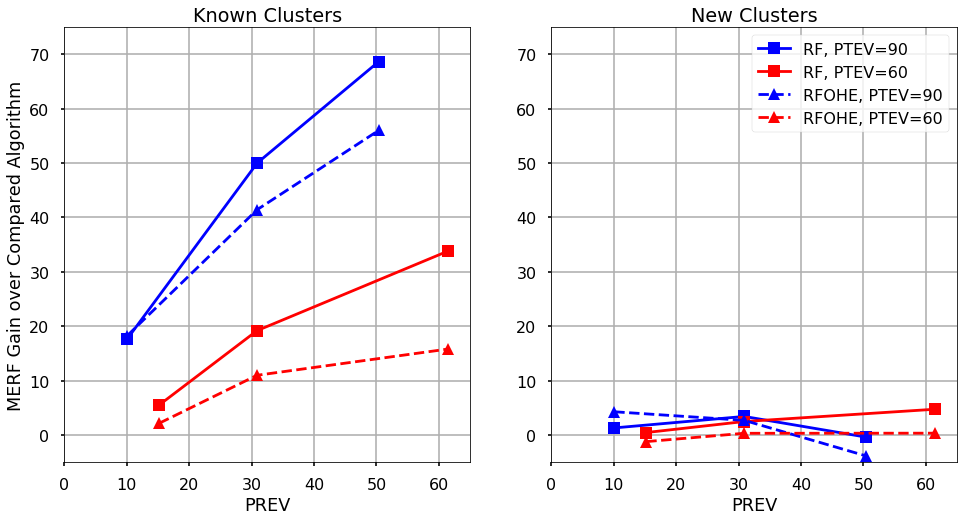

In [33]:
plt.figure(figsize=[16, 8])
plt.subplot(121)
plt.plot(summary_results.loc[0:2, 'PREV'], 
         summary_results.loc[0:2, 'Gain RF (Known)'], 'bs-', label='RF, PTEV=90')
plt.plot(summary_results.loc[3:5, 'PREV'], 
         summary_results.loc[3:5, 'Gain RF (Known)'], 'rs-', label='RF, PTEV=60')
plt.plot(summary_results.loc[0:2, 'PREV'], 
         summary_results.loc[0:2, 'Gain RFOHE (Known)'], 'b^--', label='RFOHE, PTEV=90')
plt.plot(summary_results.loc[3:5, 'PREV'], 
         summary_results.loc[3:5, 'Gain RFOHE (Known)'], 'r^--', label='RFOHE, PTEV=60')
plt.grid('on')
plt.xlabel('PREV')
plt.ylabel('MERF Gain over Compared Algorithm')
#plt.legend()
plt.title('Known Clusters')
plt.ylim([-5, 75])
plt.xlim([0, 65])
plt.subplot(122)
plt.plot(summary_results.loc[0:2, 'PREV'], 
         summary_results.loc[0:2, 'Gain RF (New)'], 'bs-', label='RF, PTEV=90')
plt.plot(summary_results.loc[3:5, 'PREV'], 
         summary_results.loc[3:5, 'Gain RF (New)'], 'rs-', label='RF, PTEV=60')
plt.plot(summary_results.loc[0:2, 'PREV'], 
         summary_results.loc[0:2, 'Gain RFOHE (New)'], 'b^--', label='RFOHE, PTEV=90')
plt.plot(summary_results.loc[3:5, 'PREV'], 
         summary_results.loc[3:5, 'Gain RFOHE (New)'], 'r^--', label='RFOHE, PTEV=60')
plt.grid('on')
plt.xlabel('PREV')
#plt.ylabel('MERF %-gain over Compared Algorithm')
plt.legend()
plt.title('New Clusters')
plt.ylim([-5, 75])
plt.xlim([0, 65])